In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import pulse2percept as p2p

2017-03-31 14:08:23,846 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
implant = p2p.implants.ElectrodeArray('epiretinal', 260, 0, 0, hs=0)

In [3]:
sim = p2p.Simulation(implant)

In [4]:
sim.set_optic_fiber_layer(sampling=100, x_range=0, y_range=0)

In [5]:
tsample = 5e-6
sim.set_ganglion_cell_layer(tsample=tsample)

In [6]:
amps = np.linspace(10, 60, 6, endpoint=True)
freqs = np.linspace(10, 100, 10, endpoint=True)
ecs = np.linspace(0.1, 1.5, 15, endpoint=True)

In [7]:
in_list = []
for a in amps:
    for f in freqs:
        for e in ecs:
            in_list.append([a, f, e])
len(in_list)

900

In [8]:
def get_pulse_train(freq, amp, tsample):
    return p2p.stimuli.PulseTrain(tsample, freq=freq, amp=amp,
                                  pulse_dur=0.45 / 1000, interphase_dur=0.45 / 1000,
                                  delay=0, pulsetype='cathodicfirst')

In [9]:
def run_pixel(params, gcl):
    a, f, e = params
    pt = get_pulse_train(f, a, gcl.tsample)
    ecm = [0, e * pt.data]
    out = gcl.model_cascade(ecm, ['GCL'], dojit=True)
    return out.data.max()

In [ ]:
out_list = p2p.utils.parfor(run_pixel, in_list, func_args=[sim.gcl], engine='joblib')

In [ ]:
pickle.dump((in_list, out_list), open('data.dat', 'wb'))

In [10]:
in_list, out_list = pickle.load(open('data.dat', 'rb'))

In [12]:
in_arr = np.array(in_list)
out_arr = np.array(out_list)

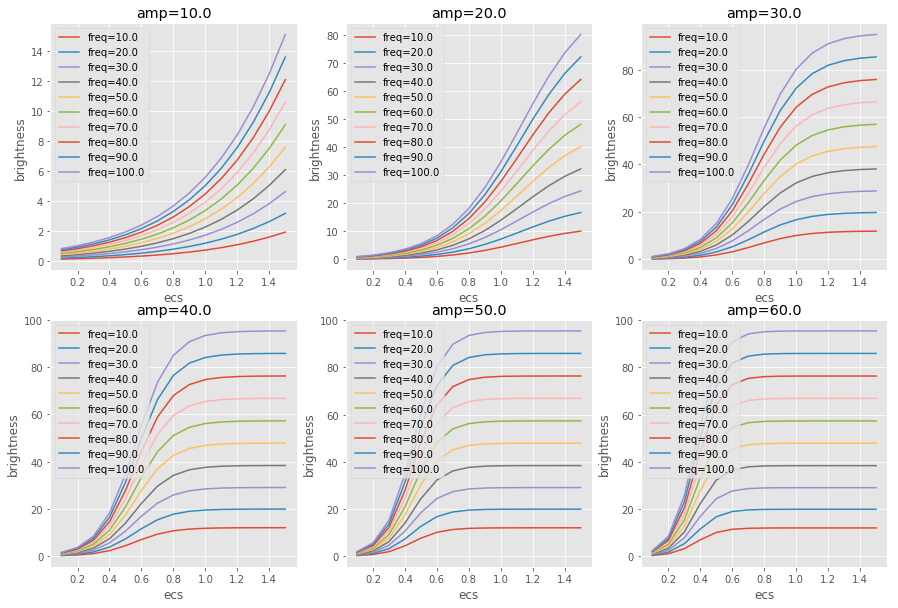

In [13]:
nr = int(np.floor(np.sqrt(len(amps))))
nc = int(np.ceil(len(amps) / nr))
plt.figure(figsize=(15, 10))

for j in range(len(amps)):
    plt.subplot(nr, nc , j + 1)
    in_slice = in_arr[j*len(freqs)*len(ecs):(j+1)*len(freqs)*len(ecs), :]
    out_slice = out_arr[j*len(freqs)*len(ecs):(j+1)*len(freqs)*len(ecs)]
    for i in range(10):
        label = 'freq=%.1f' % in_slice[i*15, 1]
        plt.plot(in_slice[i*15:(i+1)*15, -1], out_slice[i*15:(i+1)*15], label=label)
    plt.xlabel('ecs')
    plt.ylabel('brightness')
    plt.title('amp=%.1f' % amps[j])
    plt.legend()

In [14]:
from scipy.interpolate import RegularGridInterpolator

In [25]:
interp = RegularGridInterpolator((amps, freqs, ecs), out_arr.reshape((len(amps), len(freqs), len(ecs))))

In [31]:
idx = 0
for a in amps:
    for f in freqs:
        for e in ecs:
            if not np.isclose(interp([a, f, e]), out_arr[idx]):
                print('%d: %f != %f' % (idx, interp([a, f, e]), out_arr[idx]))
            idx += 1

In [33]:
interp([25, 10, 0.2])

array([ 0.2460982])

In [38]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

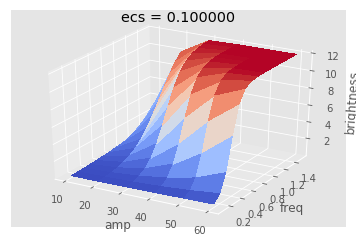

In [45]:
x,y = np.meshgrid(amps, ecs)
z = interp((x, freqs[0], y))

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('amp')
ax.set_ylabel('freq')
ax.set_zlabel('brightness')
ax.set_title('ecs = %f' % ecs[0])